Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


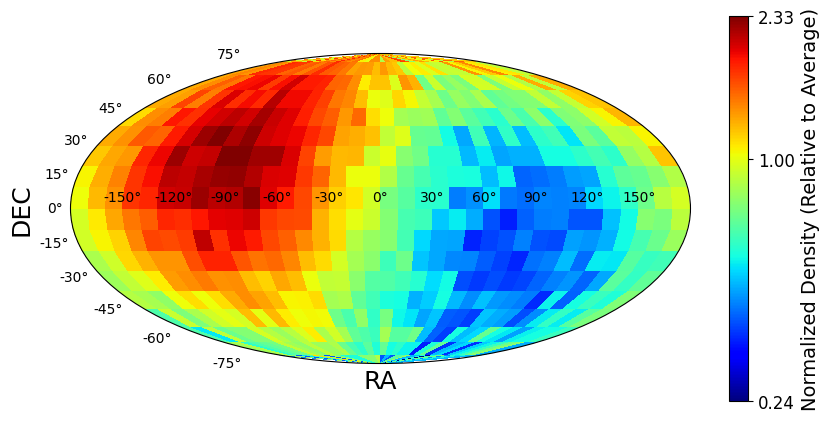

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import urllib.request

# URL do vašeg raw .txt fajla na GitHub-u
url = 'https://raw.githubusercontent.com/dusanmarceta/meteoroids/main/all_new.txt'

# Preuzimanje .txt fajla
urllib.request.urlretrieve(url, 'all_new.txt')


v, long_gal, lat_gal, long_ecl, lat_ecl, RA, DEC = np.loadtxt('all_new.txt', skiprows = 1, unpack = True)

'''
chose which coordinates to plot
'''

plot_long = RA
plot_lat = DEC

step = 10 # (degrees) division of the celestial sphere in plot_long and plot_lat



plot_long = ((plot_long + 180) % 360) - 180 # changes domain to [-180, 180] if it is [0, 360]


# bins for 2D histogram
lon_bins = np.arange(-180, 180 + step, step)
lat_bins = np.arange(-90, 90 + step, step)

# Compute 2D histogram (counts)
counts, lon_edges, lat_edges = np.histogram2d(
    plot_long, plot_lat, bins=[lon_bins, lat_bins]
)


# Convert edges to radians
lat_edges_rad = np.radians(lat_edges)
lon_edges_rad = np.radians(lon_edges)

# Compute area of each cell on the celestial sphere
lat_diff = np.abs(np.sin(lat_edges_rad[1:]) - np.sin(lat_edges_rad[:-1]))[:, np.newaxis]
lon_diff = np.abs(lon_edges_rad[1:] - lon_edges_rad[:-1])[np.newaxis, :]

area = lat_diff * lon_diff

# Compute density (counts per unit area)
density = counts / area.T

# Normalize to the average density
normalized_density = density / np.mean(density)

# Convert longitude to -180 to 180 for Mollweide projection
lon_centers = (lon_edges[:-1] + lon_edges[1:]) / 2
lon_centers = ((lon_centers + 180) % 360) - 180  # Shift to [-180, 180]

lat_centers = (lat_edges[:-1] + lat_edges[1:]) / 2
lon_grid, lat_grid = np.meshgrid(lon_centers, lat_centers)


# Define custom ticks: min, 1, max
custom_ticks = [np.min(normalized_density), 1, np.max(normalized_density)]

# Plotting the normalized density map with Mollweide projection
plt.figure(figsize=(10, 5))
ax = plt.subplot(111, projection='mollweide')
mappable = ax.pcolormesh(
    np.radians(lon_grid),
    np.radians(lat_grid),
    normalized_density.T,
    shading='auto',
    norm=LogNorm(),
    cmap='jet'
)

# Add colorbar with only min, 1, and max ticks
cbar = plt.colorbar(mappable, ax=ax)
cbar.set_ticks(custom_ticks)
cbar.set_ticklabels([f"{tick:.2f}" for tick in custom_ticks])  # Plain labels with 2 decimals

# Hide minor ticks to ensure only these three are shown
cbar.ax.minorticks_off()

# Set font size for the title, labels, and ticks
ax.set_xlabel('RA', fontsize=18)
ax.set_ylabel('DEC', fontsize=18)
cbar.set_label('Normalized Density (Relative to Average)', fontsize=14)  # Colorbar label font size
cbar.ax.tick_params(labelsize=12)  # Set font size of colorbar ticks

plt.show()